In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/detect-sarcasm-in-comments/sample_submission.csv
/kaggle/input/detect-sarcasm-in-comments/Test.csv
/kaggle/input/detect-sarcasm-in-comments/Train.csv


###### Load the data..

In [2]:
train_data = pd.read_csv(r'../input/detect-sarcasm-in-comments/Train.csv')
test_data = pd.read_csv(r'../input/detect-sarcasm-in-comments/Test.csv')
print("train size: ", train_data.shape)
print("test size: ", test_data.shape)

train size:  (15000, 10)
test size:  (8000, 9)


In [3]:
train_data.head()

,ID,comment,date,down,parent_comment,score,top,topic,user,label
0,uid_590555,"Well, let's be honest here, they don't actuall...",2015-04,0,They should shut the fuck up and let the commu...,2,2,starcitizen,Combat_Wombatz,0
1,uid_671762,"Well, I didn't need evidence to believe in com...",2016-12,-1,You need evidence to kill people? I thought we...,6,-1,EnoughCommieSpam,starkadd,1
2,uid_519689,"Who does an ""official promo"" in 360p?",2013-11,0,2014 BMW S1000R: Official Promo,3,3,motorcycles,phybere,0
3,uid_788362,Grotto koth was the best,2015-09,0,Not really that memorable lol if you want memo...,2,2,hcfactions,m0xyMC,1
4,uid_299252,Neal's back baby,2015-11,0,James Neal hit on Zach Parise,-5,-5,hockey,Somuch101,1


In [4]:
''' Looks like classes are balanced'''
train_data["label"].value_counts()

1    7527
0    7473
Name: label, dtype: int64

In [5]:
#!pip install --upgrade transformers
!pip install transformers==3.1.0

     |████████████████████████████████| 884 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 19.9 MB/s eta 0:00:01     |███▎                            | 307 kB 19.9 MB/s eta 0:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.7.0
    Uninstalling tokenizers-0.7.0:
      Successfully uninstalled tokenizers-0.7.0
  Attempting uninstall: transformers
    Found existing installation: transformers 2.11.0
    Uninstalling transformers-2.11.0:
      Successfully uninstalled transformers-2.11.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

allennlp 1.0.0 requires transformers<2.12,>=2.9, but you'll have transformers 3.1.0 which is incompatible.
You should consider upgrading via the '/opt/co

In [6]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import fastai
from fastai.text import *
from fastai.metrics import *
import transformers
from transformers import RobertaTokenizer
from transformers import RobertaForSequenceClassification

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [7]:
print("transformers version: ", transformers.__version__)
print("fast.ai version: ", fastai.__version__)

transformers version:  3.1.0
fast.ai version:  1.0.61


##### FastAI wrapper methods around Roberta Tokenizer 

In [8]:
# Creating a config object to store task specific information
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    task = "sarcasm-detection",
    testing=False,
    seed = 101,
    roberta_model_name='roberta-large', # can also be exchanged with roberta-base 
    max_lr=1e-5,
    epochs=3,
    use_fp16=False,
    bs=4, 
    max_seq_len=512, 
    num_labels = 2,
    hidden_dropout_prob=.05,
    hidden_size=768, # 1024 for roberta-large model
    start_tok = "<s>",
    end_tok = "</s>",
    mark_fields=True)

In [9]:
class FastAiRobertaTokenizer(BaseTokenizer):
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        return ["<s>"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["</s>"]
    
    
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
        super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)
         
class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_vocab, **kwargs)
        
def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]


class RobertaDataBunch(TextDataBunch):
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)
    

class RobertaTextList(TextList):
    _bunch = RobertaDataBunch
    _label_cls = TextList

###### Prepare the train & valid data 

In [10]:
''' Prepare pandas DF'''
feat_cols = "combined_comments"
label_cols = "label"

train_data["combined_comments"] = train_data["parent_comment"] + " </s> </s> " + train_data["comment"]
test_data["combined_comments"] = test_data["parent_comment"] + " </s> </s> " + test_data["comment"]

train_data[label_cols] = train_data[label_cols].astype(int)

''' Creating validation data '''
X_train, X_val, y_train, y_val = train_test_split(train_data[feat_cols], train_data[label_cols], \
                                                  test_size=0.02, random_state=99)

train_data = pd.concat([X_train, y_train], axis = 1)
val_data = pd.concat([X_val, y_val], axis = 1)


print("train shape: ", len(train_data))
print("val shape: ", len(val_data))
print("test shape: ", len(test_data))

train shape:  14700
val shape:  300
test shape:  8000


###### Look at random samples to understand the comments 

In [11]:
idx = np.random.randint(0, len(train_data), 1)
print("text: ", train_data.iloc[idx][feat_cols].values)
print("\n")
print("label: ", train_data.iloc[idx][label_cols])

text:  ['OMG! What a save! </s> </s> Close one!']


label:  9722    0
Name: label, dtype: int64


In [12]:
''' Initialize Roberta tokenizer'''
roberta_tok = RobertaTokenizer.from_pretrained(config.roberta_model_name)

fastai_tokenizer = Tokenizer(tok_func = FastAiRobertaTokenizer(roberta_tok, \
                                                               max_seq_len=config.max_seq_len), \
                             pre_rules=[], post_rules=[])

''' Construct fast.ai vocab using RobertaTokenizer dictionary'''
path = Path()
roberta_tok.save_vocabulary(path)
with open('vocab.json', 'r') as f:
    roberta_vocab_dict = json.load(f)
    
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))
print("Roberta dict size: ", len(roberta_vocab_dict.keys()))


print("Batch size is : ", config.bs)
# loading the tokenizer and vocab processors
processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)

# creating our databunch 
data = ItemLists(".", RobertaTextList.from_df(train_data, ".", cols=feat_cols, processor=processor),
                      RobertaTextList.from_df(val_data, ".", cols=feat_cols, processor=processor)
                ) \
       .label_from_df(cols=label_cols, label_cls=CategoryList) \
       .add_test(RobertaTextList.from_df(test_data, ".", cols=feat_cols, processor=processor)) \
       .databunch(bs=config.bs,pad_first=False)


Roberta dict size:  50265
Batch size is :  4


###### Model training 

In [13]:
# defining our model architecture 
class RobertaForSequenceClassificationModel(nn.Module):
    def __init__(self,num_labels=config.num_labels):
        super(RobertaForSequenceClassificationModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaForSequenceClassification.from_pretrained(config.roberta_model_name,\
                                                                        num_labels= self.num_labels)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        outputs = self.roberta(input_ids, token_type_ids, attention_mask)
        logits = outputs[0] 
        return logits

In [14]:
roberta_model = RobertaForSequenceClassificationModel(config.num_labels) 
learn = Learner(data, roberta_model, metrics=[accuracy])
learn.model.roberta.train() # setting roberta to train as it is in eval mode by default

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.o

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm

###### Plot the LR against loss

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


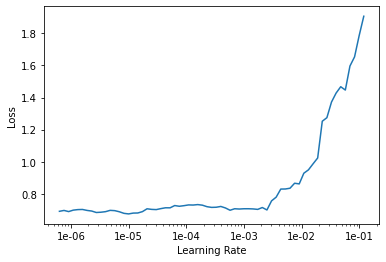

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
print("Cuda available: ", torch.cuda.is_available())
# Looks like 2 epochs are enough on Large transformers on this data
# 3 is kind of overfitting
learn.fit_one_cycle(3, max_lr=1e-6)

Cuda available:  True


epoch,train_loss,valid_loss,accuracy,time
0,0.628611,0.735646,0.573333,11:25
1,0.508020,0.594300,0.700000,11:26
2,0.501764,0.573047,0.726667,11:26


###### Inference on Validation

In [17]:
def get_preds_as_nparray(ds_type, p_learn) -> np.ndarray:
    p_learn.model.roberta.eval()
    preds = p_learn.get_preds(ds_type)[0].detach().cpu().numpy()
    
    sampler = [i for i in data.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    ordered_preds = preds[reverse_sampler, :]
    pred_values = np.argmax(ordered_preds, axis=1)
    return ordered_preds, pred_values

###### Predict validation accuracy

In [18]:
# val preds
preds, pred_values = get_preds_as_nparray(DatasetType.Valid, learn)
acc = (pred_values == data.valid_ds.y.items).mean()
print("Validation accuracy: ", acc)

Validation accuracy:  0.7266666666666667


##### Compute test predictions and save to csv

In [19]:
user_ids = []
preds = []
''' Eval mode'''
learn.model.roberta.eval()
for idx, row in test_data.iterrows():
    comment = row["combined_comments"]
    u_id = row["ID"]
    
    prediction = torch.argmax(learn.predict(comment)[2]).item()
    #print("Prediction: ", prediction)
    #print("\n")
    if idx % 100 == 0:
        print("test_idx: ", idx)
        
    user_ids.append(u_id)
    preds.append(prediction)

test_idx:  0
test_idx:  100
test_idx:  200
test_idx:  300
test_idx:  400
test_idx:  500
test_idx:  600
test_idx:  700
test_idx:  800
test_idx:  900
test_idx:  1000
test_idx:  1100
test_idx:  1200
test_idx:  1300
test_idx:  1400
test_idx:  1500
test_idx:  1600
test_idx:  1700
test_idx:  1800
test_idx:  1900
test_idx:  2000
test_idx:  2100
test_idx:  2200
test_idx:  2300
test_idx:  2400
test_idx:  2500
test_idx:  2600
test_idx:  2700
test_idx:  2800
test_idx:  2900
test_idx:  3000
test_idx:  3100
test_idx:  3200
test_idx:  3300
test_idx:  3400
test_idx:  3500
test_idx:  3600
test_idx:  3700
test_idx:  3800
test_idx:  3900
test_idx:  4000
test_idx:  4100
test_idx:  4200
test_idx:  4300
test_idx:  4400
test_idx:  4500
test_idx:  4600
test_idx:  4700
test_idx:  4800
test_idx:  4900
test_idx:  5000
test_idx:  5100
test_idx:  5200
test_idx:  5300
test_idx:  5400
test_idx:  5500
test_idx:  5600
test_idx:  5700
test_idx:  5800
test_idx:  5900
test_idx:  6000
test_idx:  6100
test_idx:  6200
test

In [27]:
#test_data.head()
#np.mean(np.array(targets) == np.array(preds))
pd.DataFrame({'ID': user_ids, 'label': preds}).to_csv("submission.csv", index=False)

###### Save the model 

In [29]:
#learn.save("roberta_large_tuned_sarcasm_model")

0    4018
1    3982
Name: label, dtype: int64

###### Load the saved model